In [1]:
#comments beginning with #BEE were written by bee martin

In [2]:
import math
import astropy
from astropy.io import ascii
import numpy as np
import emcee
from scipy.optimize import minimize
from numpy.random import normal
from numpy.random import uniform

## open file with photo-z PDF redshift bins

In [3]:
#BEE: read in table of redshifts and save the 'zshifts' column as a variable named zshifts
#BEE: zshifts is a list of redshifts from 0.4 to 4.0

In [3]:
zshifts_Table = ascii.read('fittingS82_zshifts.dat', format='csv')
zshifts = zshifts_Table['zshifts']

## open file with regression values

In [5]:
#BEE: create an array of sdss features
#BEE: read in table of regression values, create array of zeros with shape(features, redshifts)
#BEE: fill array of zeros with data from regression values table

In [4]:
sdss_features = ['u-g', 'g-r', 'r-i', 'i-z']
sdss_features_dcr = ['u-g', 'g-r', 'r-i', 'i-z', 'u-slope', 'g-slope']

color_fit_Table = ascii.read('fittingS82_zshiftfit.dat')
color_fit_Table.remove_column('col1')
color_fit = np.zeros((len(sdss_features), len(zshifts)))
color_fit_dcr = np.zeros((len(sdss_features_dcr), len(zshifts)))
for i in range(len(sdss_features)):
    for j in range(len(zshifts)):
        color_fit[i,j] = np.asarray(color_fit_Table[i][j])

for i in range(len(sdss_features_dcr)):
    for j in range(len(zshifts)):
        color_fit_dcr[i,j] = np.asarray(color_fit_Table[i][j])

In [7]:
print(color_fit)

[[0.379  0.2507 0.2023 ... 1.8216 2.3703 2.501 ]
 [0.1143 0.0644 0.041  ... 1.1345 1.3296 1.4278]
 [0.1995 0.2651 0.2679 ... 0.1156 0.1086 0.1483]
 [0.2466 0.2032 0.1762 ... 0.1389 0.0744 0.0881]]


In [35]:
print(color_fit_Table)

 col2   col3   col4   col5    col6  ...  col463  col464  col465  col466  col467
------ ------ ------ ------ ------- ... ------- ------- ------- ------- -------
 0.379 0.2507 0.2023 0.3056  0.3419 ...  2.1726  1.7256  1.8216  2.3703   2.501
0.1143 0.0644  0.041 0.0252  0.0727 ...  1.2433   1.135  1.1345  1.3296  1.4278
0.1995 0.2651 0.2679 0.2351  0.1867 ...  0.1163  0.1366  0.1156  0.1086  0.1483
0.2466 0.2032 0.1762 0.1314   0.157 ...  0.1022  0.1582  0.1389  0.0744  0.0881
0.0012 0.0053 0.0002 -0.014 -0.0083 ... -0.0215 -0.0029  0.0225 -0.0089 -0.0468
0.0258 0.0506 0.0589 0.0357  0.0143 ... -0.0186 -0.0126 -0.0221 -0.0576 -0.0655


## open file with regression covariance values

In [7]:
#BEE: read in regression covariance data
#BEE: create array of zeros with shape (features, features, redshifts), fill it with covariance table data

In [8]:
color_covariance_Table = ascii.read('fittingS82_zshiftcovariance.dat')
color_covariance_Table.remove_column('col1')
color_covariance_Table.remove_column('col2')
color_covariance = np.zeros((len(sdss_features), len(sdss_features), len(zshifts)))
color_covariance_dcr = np.zeros((len(sdss_features_dcr), len(sdss_features_dcr), len(zshifts)))  
l = 0
for i in range(len(sdss_features_dcr)):
    for j in range(len(sdss_features_dcr)):
        for k in range(len(zshifts)):
            color_covariance_dcr[i,j,k] = np.asarray(color_covariance_Table[l][k])
        l += 1
color_covariance = color_covariance_dcr[:4, :4, :]
#print(color_covariance_dcr)
#print(color_covariance)

## open file with the simulated quasar true values

In [9]:
#BEE: Read in simulated "true" quasar data

In [9]:
test_quasars0 = ascii.read('random_quasars.dat')
test_quasars = ascii.read('random_quasars100k.dat')[:1000]
print(test_quasars.keys())

['zspec', 'u-g', 'g-r', 'r-i', 'i-z', 'u-slope', 'g-slope', 'uerr', 'gerr', 'rerr', 'ierr', 'zerr', 'u-slopeerr', 'g-slopeerr']


## define the observations

In [11]:
#BEE: simulate airmass observations in u ang g

In [10]:
astrometric_error = [0.035,0.025]  #[u-band error, g-band error]

airmasses = uniform(low=1.0, high=1.3, size=50)
airmasses = np.append(airmasses, uniform(low=1.3, high=2.0, size=14))

filters = np.tile(['u', 'g'], int(len(airmasses)/2))

In [11]:
#BEE: this cell will take observations from the OpSim rather than simulating them
astrometric_error = [0.035, 0.025]
#astrometric_error = [0.07, 0.05]
    
dcr = np.load('dcr.npz')
print(list(dcr.keys()))
dcrra_dec = dcr['ra_dec']
dcrdata = dcr['data']
print(dcrra_dec[0])
#obs_g = dcrdata[1][dcrdata[1]['filter']=='g']
#obs_u = dcrdata[1][dcrdata[1]['filter']=='u']
#obs = np.concatenate((obs_g, obs_u))

['ra_dec', 'data']
(0., -60.)


GTR: Split out cell that defines airmasses.  Just define one at a time.  Predefine the experiments and comment out the ones being run each time.  Make sure that the output files are unique for each experiment.

GTR: Run colors only and colors+normal DCR just once.  We don't need to run those again.  But those can be the first 2 "experiments".

In [14]:
#airmasses = np.array([item[1] for item in obs])
#filters = np.array([item[3] for item in obs])
#airmasses_long = np.append(airmasses, [1.6, 1.6])
#filters_long = np.append(filters, ['g', 'g'])
#airmasses_twilight = np.append(airmasses, [2.0, 2.0])
#filters_twilight = np.append(filters, ['g', 'g'])

BEE: The next cell is a switch that lets you choose the experiment to run.  There are 2 types of experiments: 'substitution' and 'addition'.  Change the string in the cell to either 'substitution' or 'addition'.  The airmasses should be 1.6, 1.7, 1.8, 1.9, or 2.0.  In the case of addition, you can set airmass_to_use to an array of airmasses and it will add all of them.  NOTE: Make sure, if you're running multiple experiments, to run the cell above for each one so you don't overwrite the wrong airmasses array.

In [15]:
#experiment_to_run = 'substitution'
experiment_to_run = 'addition'
airmass_to_use = [1.6,1.6,1.7,1.7,1.8,1.8,1.9,1.9,2,2]

In [16]:
if experiment_to_run == 'substitution':    
    #airmass_to_substitute = airmass_to_use[0]
    #index_of_lowest = np.argmin(airmasses)
    #airmasses[index_of_lowest] = airmass_to_substitute
    save_file_name = 'AstroMetric_SubstitutionDCR_' + str(int(airmass_to_substitute*10)) + '.npz'

In [17]:
if experiment_to_run == 'addition':
    #filters_to_add = np.tile('g', int(len(airmass_to_use)))
    #airmasses = np.append(airmasses, airmass_to_use)
    #filters = np.append(filters, filters_to_add)
    save_file_name = 'AstroMetric_TwilightDCR_' + str([int(airmass_to_use[i]*10) for i in range(len(airmass_to_use))]) + '.npz'

In [18]:
#print(airmasses)
#print(filters)
#print(save_file_name)

## generate observed slopes from true slopes and observations

In [19]:
#BEE: lnlike calculates the loglikelihood, lnprior creates a prior on our linear fits, lnprob adds the prior to lnlike
#BEE: run_fit runs the mcmc walkers over a range of linear fits and selects the median as the best fit and half the 
#     difference between 16th and 84th percentiles as the error

In [12]:
def lnlike(theta, x, y, yerr):
    m, lnf = theta
    model = m*x
    inv_sigma2 = 1.0/(yerr**2. + model**2.*np.exp(2.*lnf))
    return -0.5*(np.sum(((y-model)**2.*inv_sigma2 - np.log(inv_sigma2))))

def lnprior(theta):
    m, lnf = theta
    if (-1.0 < m < 1.0) and (-100.0 < lnf < 100.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

def run_fit(tanZList, RList, RerrList):
    nll = lambda *args: -lnprob(*args)
    x = np.copy(tanZList)
    y = np.copy(RList)
    yerr = np.copy(RerrList)
    #first do a simple minimization to get starting values for mcmc
    pm = np.random.choice([-1.0,1.0], size=len(x), replace=True)
    result = minimize(nll, [-0.001, np.log(0.5)], args=(x, y, yerr))
    m_ml, lnf_ml = result["x"]
    #now run mcmc
    ndim, nwalkers = 2, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    ms = samples[np.random.randint(len(samples), size=100)][:,0]
    # return the median walker as the best slope and the half the 16-84th percentiles as the error
    m_mcmc, lnf_mcmc = map(lambda v: (v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    merr_mcmc, lnf_mcmc = map(lambda v: (0.5*(v[2]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    return m_mcmc, merr_mcmc

In [13]:
import random
random.seed(42)

GTR: Split out cells that define functions from cells that make calls to those functions.

In [14]:
#def dcrSlopeCalc(airmasses, filters, test_quasars):
def dcrSlopeCalc(experiment_to_run, airmass_to_use, dcrdata, test_quasars):    

    astrometric_error = [0.035, 0.025]
    #astrometric_error = [0.0035, 0.0025]
    #astrometric_error = [0.07, 0.05]
    obs_slopes_u    = np.zeros((len(test_quasars)))
    obs_slopes_uerr = np.zeros((len(test_quasars)))
    obs_slopes_g    = np.zeros((len(test_quasars)))
    obs_slopes_gerr = np.zeros((len(test_quasars)))

    for i in range(len(test_quasars)):
        
        idx = random.randrange(len(dcrdata))
        obs_g = dcrdata[idx][dcrdata[idx]['filter']=='g']
        obs_u = dcrdata[idx][dcrdata[idx]['filter']=='u']
        obs = np.concatenate((obs_g, obs_u))
        airmasses = np.array([item[1] for item in obs])
        filters = np.array([item[3] for item in obs])

        if experiment_to_run == 'substitution':    
            airmass_to_substitute = airmass_to_use[0]
            index_of_lowest = np.argmin(airmasses)
            airmasses[index_of_lowest] = airmass_to_substitute
    
        if experiment_to_run == 'addition':
            filters_to_add = np.tile('u', int(len(airmass_to_use)))
            #filters_to_add = np.tile('g', int(len(airmass_to_use)))
            airmasses = np.append(airmasses, airmass_to_use)
            filters = np.append(filters, filters_to_add)
        
        true_slope_u = test_quasars['u-slope'][i]
        true_slope_g = test_quasars['g-slope'][i]
    
        tanZList_u = np.array([])
        RerrList_u = np.array([])
        RList_u = np.array([])
        tanZList_g = np.array([])
        RerrList_g = np.array([])
        RList_g = np.array([])
    
        for j, airmass in enumerate(airmasses):
            tanZ_obs = np.tan(np.arccos(1.0/airmass)) #tangent of zenith angle of this observation
            if filters[j] == 'u':
                #calculate the observed offset
                #random scatter around the true offset using a normal distribution with the astrometric error as the standard deviation
                R_obs = normal(true_slope_u*tanZ_obs, astrometric_error[0])
                tanZList_u = np.append(tanZList_u, tanZ_obs)              #list of x axis values
                RerrList_u = np.append(RerrList_u, astrometric_error[0])  #list of y axis error values
                RList_u = np.append(RList_u, R_obs)                       #list of y axis values
            if filters[j] == 'g':
                R_obs = normal(true_slope_g*tanZ_obs, astrometric_error[1])
                tanZList_g = np.append(tanZList_g, tanZ_obs)
                RerrList_g = np.append(RerrList_g, astrometric_error[1])
                RList_g = np.append(RList_g, R_obs)
    
        # fit a stright line through the x and y values, using the y-err values
        m_mcmc_u, merr_mcmc_u = run_fit(tanZList_u, RList_u, RerrList_u)
        m_mcmc_g, merr_mcmc_g = run_fit(tanZList_g, RList_g, RerrList_g)
        obs_slopes_u[i] = m_mcmc_u
        obs_slopes_uerr[i] = merr_mcmc_u
        obs_slopes_g[i] = m_mcmc_g
        obs_slopes_gerr[i] = merr_mcmc_g
        
        if (i==0):
            print(true_slope_g,obs_slopes_g[i])
            import matplotlib.pyplot as plt
            %matplotlib inline
            plt.figure(figsize=[10,10])
            plt.xlabel('Airmass')
            plt.ylabel('Offset')
            #plt.xlim(0.5,0.75)
            #plt.ylim(0,0.4)
            tanZgrid = np.linspace(0,1.8,1000)
            yFit = tanZgrid*obs_slopes_u[i] + 0
            yTrue = tanZgrid*true_slope_u + 0    
            plt.scatter(tanZList_u,RList_u,label='data')
            plt.plot(tanZgrid,yTrue,label='True')
            plt.plot(tanZgrid,yFit,label='Fit')
            plt.legend()
            plot_save_name = save_file_name[:-4] + '_slopes.pdf'
            plt.savefig(plot_save_name)
            
    return obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr

In [17]:
experiment_to_run = 'addition'
airmass_to_use = []
save_file_name = 'TestJune2020_' + str([int(airmass_to_use[i]*10) for i in range(len(airmass_to_use))]) + '.npz'

0.0201 0.02018233836832161


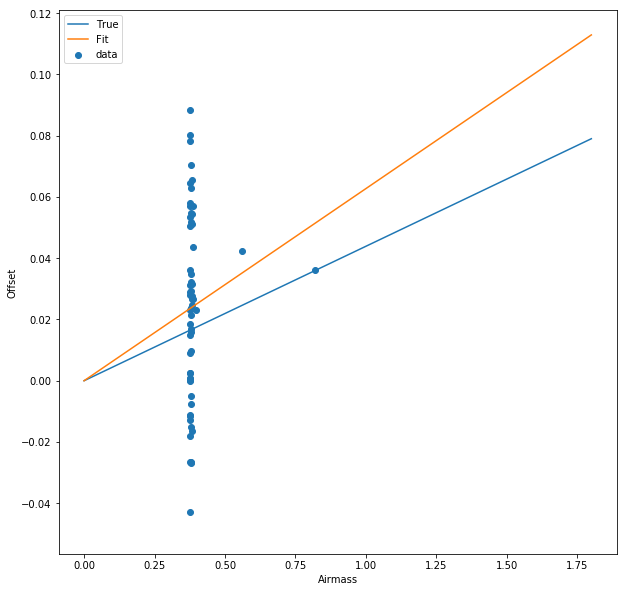

In [18]:
obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr = dcrSlopeCalc(experiment_to_run, airmass_to_use, dcrdata, test_quasars)
obs_parameters = np.vstack([test_quasars['u-g'], test_quasars['g-r'], test_quasars['r-i'], test_quasars['i-z'], obs_slopes_u, obs_slopes_g, test_quasars['uerr'], test_quasars['gerr'], test_quasars['rerr'], test_quasars['ierr'], test_quasars['zerr'], obs_slopes_uerr, obs_slopes_gerr])
deltaSlope_u = np.subtract(test_quasars['u-slope'], obs_slopes_u)
deltaSlope_g = np.subtract(test_quasars['g-slope'], obs_slopes_g)

## calculate redshift PDFs for observed quasars

In [19]:
def calculate_PDFs(parameters, zshifts, feature_zshift_fit, feature_covariance):
    
    num_features = int((np.shape(parameters)[0]-1)/2)
    num_of_quasars = np.shape(parameters)[1]
    
    #empty arrays to be filled
    feature_distance =  np.zeros((num_of_quasars, num_features, len(zshifts)))
    prob = np.zeros((num_of_quasars, len(zshifts)))
    chi_squared =  np.zeros((num_of_quasars, len(zshifts)))
    for i in range(num_of_quasars):
        #empty arrays to be filled
        features = np.zeros((num_features))
        covariance_matrix_of_features = np.zeros((num_features,num_features))
        
        # loop through all the features (e.g. 'u-g', 'g-r', 'r-i', 'i-z', 'u-slope', 'g-slope')
        for j in range(num_features):
            for k in range(num_features):
                if (j == k):
                    if j < 4:
                        # covaraince between the colors, on the diagonal
                        covariance_matrix_of_features[j,k] = parameters[j+num_features,i]**2.0 + parameters[j+num_features+1,i]**2.0
                    else:
                        # covaraince between the slopes, on the diagonal
                        covariance_matrix_of_features[j,k] = parameters[j+num_features+1,i]**2.0
                elif abs(j - k) == 1:
                    if j > k:
                        if j < 4:
                            # covaraince between the colors, just off the diagonal
                            covariance_matrix_of_features[j,k] = -1.0*parameters[j+num_features,i]**2.0
                    if k > j:
                        if k < 4:
                            # covaraince between the slopes, just off the diagonal
                            covariance_matrix_of_features[j,k] = -1.0*parameters[k+num_features,i]**2.0
            # difference between the features of this quasar and the regression calculate for all the quasars
            features[j] = parameters[j,i]
            feature_distance[i,j,:] = np.abs(features[j] - feature_zshift_fit[j,:])
        for z in range(len(zshifts)):
            # linear algebra from Weinstein et al. 2004
            A = np.matrix(feature_distance[i,:,z])
            B = np.matrix(covariance_matrix_of_features[:,:])
            C = np.matrix(feature_covariance[:,:,z])
            chi_squared[i,z] = np.dot(np.dot(A, (B + C).I), A.T)
            try:
                prob[i,z] = (np.exp(-1.0*chi_squared[i,z]/2.0))/(4.0*(math.pi**2.0)*(np.linalg.det(B + C)**0.5))
                #if np.isnan(prob[i,z]):
                    #prob[i,z] = 1e-250
                    #prob[i,z] = (np.finfo(np.float64).tiny)
            except:
                prob[i,z] = 0.0
        # normalize the probabilities
        sum_of_array = np.nansum(prob[i,:], axis=0, dtype=np.float64)
        try:
            prob[i,:] = prob[i,:]/sum_of_array
        except:
            prob[i,:] = 0.0*prob[i,:]
    return prob

In [20]:
#calculate the pdf of the redshift
obs_photoz_PDFs = calculate_PDFs(obs_parameters, zshifts, color_fit_dcr, color_covariance_dcr)
'''
#dcr of opsim alone pdf
obs_photoz_PDFs_dcr1 = calculate_PDFs(obs_parameters_dcr1, zshifts, color_fit_dcr, color_covariance_dcr)
#dcr of opsim+longer observation time
obs_photoz_PDFs_dcr2 = calculate_PDFs(obs_parameters_dcr2, zshifts, color_fit_dcr, color_covariance_dcr)
#dcr of opsim+twilight survey
obs_photoz_PDFs_dcr3 = calculate_PDFs(obs_parameters_dcr3, zshifts, color_fit_dcr, color_covariance_dcr)
'''

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


'\n#dcr of opsim alone pdf\nobs_photoz_PDFs_dcr1 = calculate_PDFs(obs_parameters_dcr1, zshifts, color_fit_dcr, color_covariance_dcr)\n#dcr of opsim+longer observation time\nobs_photoz_PDFs_dcr2 = calculate_PDFs(obs_parameters_dcr2, zshifts, color_fit_dcr, color_covariance_dcr)\n#dcr of opsim+twilight survey\nobs_photoz_PDFs_dcr3 = calculate_PDFs(obs_parameters_dcr3, zshifts, color_fit_dcr, color_covariance_dcr)\n'

## calculate the peaks of the redshift PDFs

In [21]:
def photozPDF_to_pointestimate(photoz_PDFs, zshifts):
    prob_threshold = 1.0/len(photoz_PDFs[0,:]) #threshold is above if all the probability were equally distributed
    num_of_quasars = len(photoz_PDFs[:,0])
    photoz_peaks = np.zeros((num_of_quasars))
    for i in range(num_of_quasars):
        zpeaks = np.array([])
        zprobs = np.array([])
        # all the non-nan values
        good_idxs = np.arange(len(photoz_PDFs[i,:]), dtype=np.int)[~np.isnan(photoz_PDFs[i,:])]
        # all the non-nan values above the probability threshold
        good_idxs_high = good_idxs[np.where(photoz_PDFs[i,:][~np.isnan(photoz_PDFs[i,:])] > prob_threshold)[0]]
        above_prob_threshold = list(good_idxs_high)
        # only find peaks if there is a value above the threshold
        if len(above_prob_threshold[1:-1]) > 1:
            # find all the contiguous bins above the probability threshold, these are the bumps in the PDF
            ranges = sum((list(t) for t in zip(above_prob_threshold, above_prob_threshold[1:]) if t[0]+1 != t[1]), [])
            # add the edges of the redshift range back on
            iranges = above_prob_threshold[0:1] + ranges + above_prob_threshold[-1:]
            # find the peak of each of the bumps
            for peaks in range(int(len(iranges)/2)):
                peak_zmin = iranges[int(peaks*2):int(peaks*2) + 2][0]
                peak_zmax = iranges[int(peaks*2):int(peaks*2) + 2][1]
                peak_maxprob = zshifts[peak_zmin:peak_zmax+1][np.argmax(photoz_PDFs[i,peak_zmin:peak_zmax+1])]
                # only count the peak if it isn't the minimum or maximum redshift bin
                # there can be weird edge effects in the PDFs, so we don't want those peaks
                if (peak_maxprob != zshifts[0]) and (peak_maxprob != zshifts[-1]):
                    zpeaks = np.append(zpeaks, peak_maxprob)
                    # the probability of that peak is all the area under the bump
                    zprobs = np.append(zprobs, np.sum(photoz_PDFs[i,peak_zmin:peak_zmax+1]))
                else:
                    zpeaks = np.append(zpeaks, peak_maxprob)
                    zprobs = np.append(zprobs, 0.0)
            photoz_peaks[i] = zpeaks[np.argmax(zprobs)]
        else:
            photoz_peaks[i] = np.nan
    return photoz_peaks

In [22]:
obs_photoz_peaks = photozPDF_to_pointestimate(obs_photoz_PDFs, zshifts)
#obs_photoz_peaks_dcr1 = photozPDF_to_pointestimate(obs_photoz_PDFs_dcr1, zshifts)
#obs_photoz_peaks_dcr2 = photozPDF_to_pointestimate(obs_photoz_PDFs_dcr2, zshifts)
#obs_photoz_peaks_dcr3 = photozPDF_to_pointestimate(obs_photoz_PDFs_dcr3, zshifts)
print(obs_photoz_peaks)

[1.795 2.8   0.985 1.47  2.325 1.47  2.535 3.4   2.77  3.14  1.825 1.025
 1.56  1.81  0.85  3.45  3.425 0.625 1.225 1.805 2.7   1.93  2.73  1.565
 2.94  1.455 0.82  1.475 3.375 0.85  3.425 2.76  2.015 0.85  2.025 1.225
 2.8   2.75  2.535 2.73  3.4   1.445 1.455 1.965 1.05  2.54  2.79  0.995
 1.825 2.005 0.625 3.45  3.7   0.66  2.96  3.275 0.985 2.535 1.31  1.225
 2.02  1.84  3.9   1.81  1.065 1.225 3.65  2.7   1.445 0.85  1.775 1.225
 1.515 0.85  1.115 2.28  2.06  1.025 1.865 0.625 1.225 3.14  1.465 2.8
 1.56  2.8   2.94  1.225 1.47  1.44  2.025 3.14  1.025 0.82  3.15  2.8
 0.82  1.065 3.8   1.965 2.555 3.4   1.535 1.775 1.935 3.45  2.8   3.65
 3.75  3.75  3.7   3.4   1.045 2.335 1.805 2.77  1.455 2.94  2.71  1.76
 1.465 2.535 1.985 2.555 2.04  1.225 3.6   1.225 1.085 2.73  3.65  3.95
 3.7   1.46  0.82  1.905 2.025 0.79  1.455 0.65  1.58  1.225 0.79  1.31
 2.8   1.515 3.7   0.835 1.84  1.985 3.45  2.8   2.54  3.7   2.94  3.9
 0.85  0.75  1.225 1.57  1.515 2.75  2.555 3.65  1.985 1.035 

## Save Experiment

In [23]:
fileName = save_file_name
test_quasars_zspec = test_quasars['zspec']
np.savez(fileName, 
         airmasses=airmasses,
         filters=filters,
         deltaSlope_g=deltaSlope_g, 
         deltaSlope_u=deltaSlope_u, 
         z_phot=obs_photoz_peaks,
         z_true=test_quasars_zspec,
         redshift=zshifts)

## write out the simulated quasars

In [24]:
test_quasars_zspec = test_quasars['zspec']

with open('simulatedquasars_photozPDFs.dat', "w") as file_name:
    file_name.write("#zspec photozpeak photozPDF")
    file_name.write("\n")
    for i in range(len(test_quasars_zspec)):
        file_name.write("%0.4f %0.4f " % (test_quasars_zspec[i], obs_photoz_peaks[i]))
        for j in range(len(obs_photoz_PDFs[i,:])):
            file_name.write("%0.4f " % (obs_photoz_PDFs[i,j]))
        file_name.write("\n")

with open('simulatedquasars_obsparameters.dat', "w") as file_name:
    file_name.write("#zspec u-g g-r r-i i-z u-slope g-slope uerr gerr rerr ierr zerr u-slopeerr g-slopeerr")
    file_name.write("\n")
    for i in range(len(test_quasars_zspec)):
        for j in range(len(obs_parameters[:,i])):
            file_name.write("%0.4f " % (obs_parameters[j,i]))
        file_name.write("\n")

GTR: Have everything below read in data files in order to produce plots.  Let's just make single panels instead of 2x2.  We can build those if need be.

GTR: Add z_spec vs. zphot plots and Delta z histograms

## calculate the redshift quality metric

In [25]:
def photo_z_robust_stdev(z_est, z_true, zshifts):
    """
    Sort the delta_z data into redshift bins in z_true.
    Delta_z is defined as (z_true - z_est) / (1. + z_true).
    
    Calculate the robust standard deviation in each bin as a function of true redshift.
    Robust standard deviation is defined as the standard deviation of delta_z in the bin where delta_z
    is defined as (z_true - z_est) / (1. + z_true) and we trim the highest and lowest 25% of delta_z values.
    """

    delta_z = (z_true - z_est) / (1. + z_true)
    idx_sort = z_true.argsort()
    delta_z_sort = delta_z[idx_sort]
    z_true_sort = z_true[idx_sort]
    idx_bins = z_true_sort.searchsorted(zshifts)
    delta_z_binned = [delta_z_sort[idx_bins[i]:idx_bins[i+1]] for i in range(len(zshifts)-1)]
    stdev_iqr_results = []
    for delta_z_data in delta_z_binned:
        if len(delta_z_data) == 0:
            stdev_iqr_results.append(np.nan)
            continue
        bin_25 = np.percentile(delta_z_data, 25.)
        bin_75 = np.percentile(delta_z_data, 75.)
        diff = bin_75 - bin_25
        stdev_iqr_results.append(diff/1.349)
    return np.array(stdev_iqr_results)

## Load in Save File

In [26]:
#put the name of the file you want to plot from here
#file_to_load = 'this_is_a_placeholder.npz'  #Defaults to file that was just created, but can be changed
file_to_load = save_file_name
plot_data = np.load(file_to_load)
print(file_to_load[:-4])

TestJune2020_[]


In [27]:
#calculate standard deviation of zphot over the interquartile range
stdev_iqr = photo_z_robust_stdev(plot_data['z_phot'], plot_data['z_true'], plot_data['redshift'])

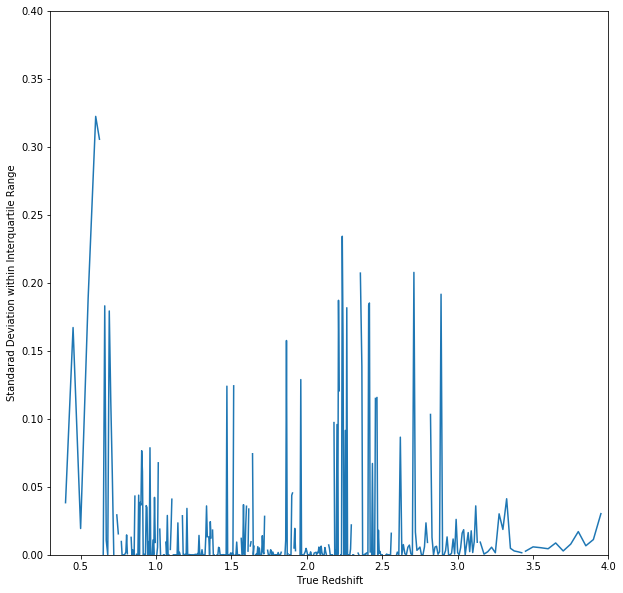

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[10,10])
plt.xlabel('True Redshift')
plt.ylabel('Standarad Deviation within Interquartile Range')
plt.xlim(0.3,4)
plt.ylim(0,0.4)
plt.plot(plot_data['redshift'][:-1], stdev_iqr)
plot_save_name = file_to_load[:-4] + '_stdev_iqr_plot.pdf'
plt.savefig(plot_save_name)

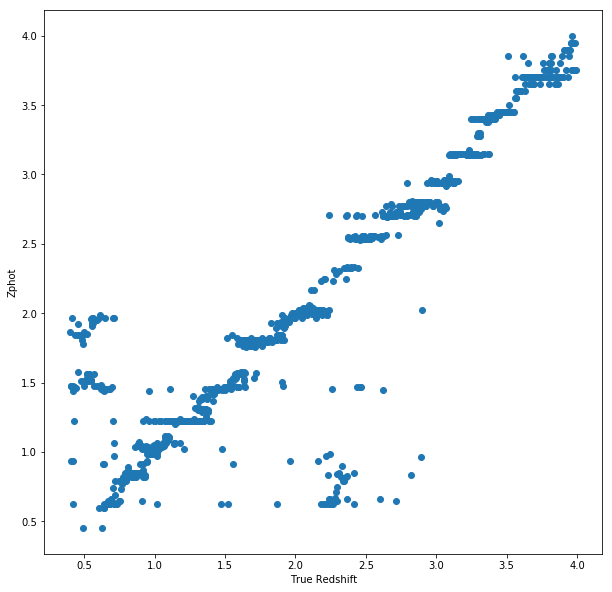

In [29]:
plt.figure(figsize=[10,10])
plt.xlabel('True Redshift')
plt.ylabel('Zphot')
plt.scatter(plot_data['z_true'], plot_data['z_phot'])
#print(plot_data['z_true']-plot_data['z_phot'])
#print(plot_data['z_true'])
plot_save_name = file_to_load[:-4] + '_ztrue_vs_zphot_plot.pdf'
plt.savefig(plot_save_name)

0.012950000000000073


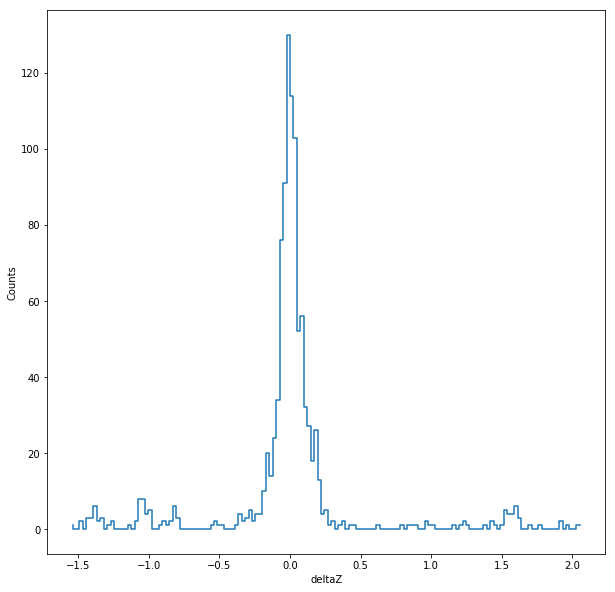

In [30]:
deltaZ = np.subtract(plot_data['z_true'], plot_data['z_phot'])
deltaZ = deltaZ[~np.isnan(deltaZ)]
print(np.median(deltaZ))
ydata, bin_edges = np.histogram(deltaZ, bins='fd')
#ydata, bin_edges = np.histogram(deltaZ, bins=10)
bins = 0.5*(bin_edges[:-1]+bin_edges[1:])
#print(ydata, bin_edges, bins)
#z_err = np.divide(deltaZ, [1+z for z in plot_data['z_true']])
plt.figure(figsize=[10,10])
plt.xlabel('deltaZ')
plt.ylabel('Counts')
#plt.hist(ydata,bin_edges)
plt.step(bins,ydata)
plot_save_name = file_to_load[:-4] + '_deltaZ_hist_plot.pdf'
#plt.xlim(-0.2,0.2)
plt.savefig(plot_save_name)

In [31]:
stdev_iqr = stdev_iqr[~np.isnan(stdev_iqr)]
print('Total STD_DEV_IQR=',stdev_iqr.sum())

Total STD_DEV_IQR= 7.335333751911996
